Exploration of the MSSubClass variable. The description of the variable is, "Identifies the type of dwelling involved in the sale". Possible values are:

* `20     1-STORY 1946 & NEWER ALL STYLES`
* `30     1-STORY 1945 & OLDER`
* `40     1-STORY W/FINISHED ATTIC ALL AGES`
* `40     1-1/2 STORY - UNFINISHED ALL AGES`
* `50     1-1/2 STORY FINISHED ALL AGES`
* `60     2-STORY 1946 & NEWER`
* `70     2-STORY 1945 & OLDER`
* `75     2-1/2 STORY ALL AGES`
* `80     SPLIT OR MULTI-LEVEL`
* `85     SPLIT FOYER`
* `90     DUPLEX - ALL STYLES AND AGES`
* `120    1-STORY PUD (Planned Unit Development) - 1946 & NEWER`
* `150    1-1/2 STORY PUD - ALL AGES`
* `160    2-STORY PUD - 1946 & NEWER`
* `180    PUD - MULTILEVEL - INCL SPLIT LEV/FOYER`
* `190    2 FAMILY CONVERSION - ALL STYLES AND AGES`

In [4]:
%matplotlib inline

import pandas as pd
import seaborn as sns
from scipy.stats import randint
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

from house_prices.helpers.column_categories import continuous_columns, categorical_unordered_columns, categorical_ordered_columns
from house_prices.helpers.utils import association_matrix, anova_with_effect_size, anova_matrix

sns.set(rc={'figure.figsize':(15,10)})

In [2]:
train = pd.read_csv('../data/train.csv', index_col=0).loc[:, ['MSSubClass', 'SalePrice']]

In [3]:
print(train.shape)
print(train['MSSubClass'].isnull().sum())

(1460, 2)
0


We have 1460 rows in the dataset and MSSubClass has no null values. Let's look at the distribution of values.

In [4]:
train['MSSubClass'].value_counts()

20     536
60     299
50     144
120     87
30      69
160     63
70      60
80      58
90      52
190     30
85      20
75      16
45      12
180     10
40       4
Name: MSSubClass, dtype: int64

67% of all houses come from one of three MSSubClass values; 36.7% are 1-STORY 1946 & NEWER ALL STYLES, 20.5% are 2-STORY 1946 & NEWER, and 9.9% are 1-1/2 STORY FINISHED ALL AGES. These seem to be the standard types when considering houses that exist in a suburban setting.

Let's turn to the variable's relationship with SalePrice.

In [5]:
median_price_by_mssubclass = train.groupby('MSSubClass')['SalePrice'].median().sort_values()
print(median_price_by_mssubclass)

MSSubClass
180     88500
30      99900
45     107500
190    128250
50     132000
90     135980
85     140750
40     142500
160    146000
70     156000
20     159250
75     163500
80     166500
120    192000
60     215200
Name: SalePrice, dtype: int64


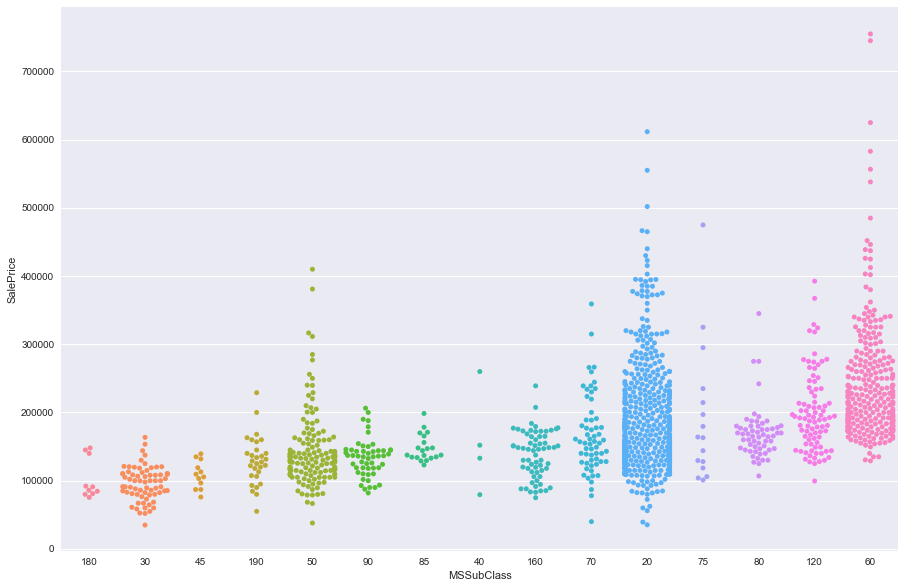

In [6]:
sns.swarmplot(x='MSSubClass', y='SalePrice', order=median_price_by_mssubclass.index, data=train);

Let's check out the clustering by number of floors, year of building, pud vs. non-pud, split vs. non-split, and whatever else seems interesting.

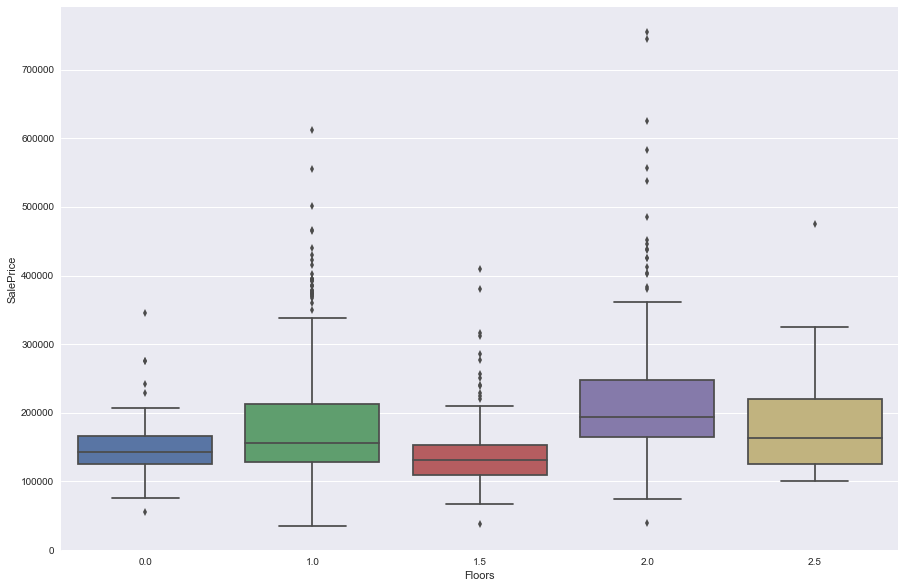

In [7]:
floor_mapping = {20: 1, 30: 1, 40: 1, 45: 1.5, 50: 1.5, 60: 2, 70: 2, 75: 2.5, 80: 0, 85: 0, 90: 0, 120: 1, 150: 1.5,
                 160: 2, 180: 0, 190: 0}
train['Floors'] = train.MSSubClass.map(floor_mapping)

sns.set(rc={'figure.figsize':(15,10)})
sns.boxplot(x='Floors', y='SalePrice', data=train);

In [8]:
train.groupby('Floors')['SalePrice'].median()

Floors
0.0    142976.5
1.0    156250.0
1.5    130750.0
2.0    194000.0
2.5    163500.0
Name: SalePrice, dtype: float64

We can see 2 level homes have the highest prices. 1.5 level homes have lower prices than 1 level homes. 2.5 level homes have lower prices than 2 level homes. There are a fair amount of home categories where the number of floors is not immediately evident, and their prices are somewhere between those with 1 and 1.5 levels.

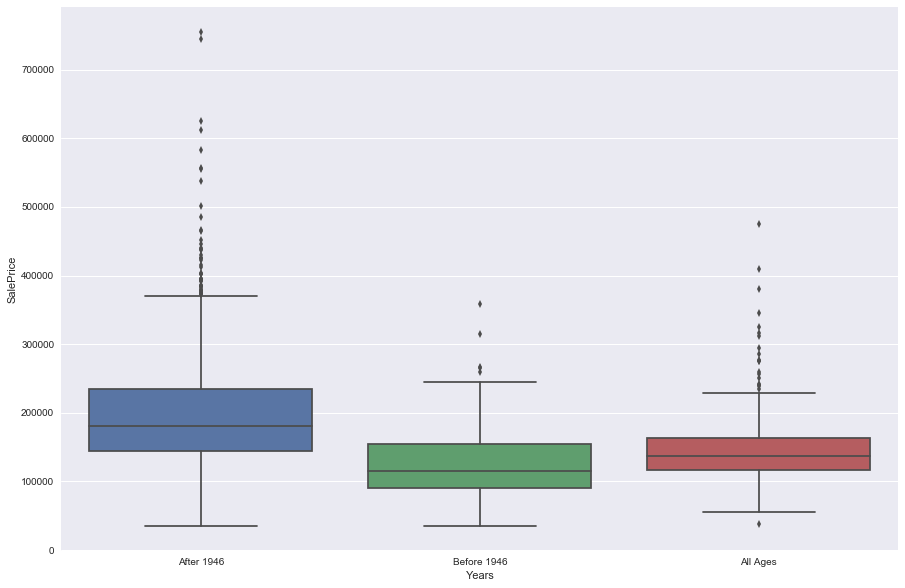

In [9]:
year_mapping = {20: 0, 30: 1, 40: 2, 45: 2, 50: 2, 60: 0, 70: 1, 75: 2, 80: 2, 85: 2, 90: 2, 120: 0, 150: 2, 160: 0, 180: 2, 
                190: 2}
train['Years'] = train.MSSubClass.map(year_mapping)

sns.set(rc={'figure.figsize':(15,10)})
sns.boxplot(x='Years', y='SalePrice', data=train).set_xticklabels(['After 1946', 'Before 1946', 'All Ages']);

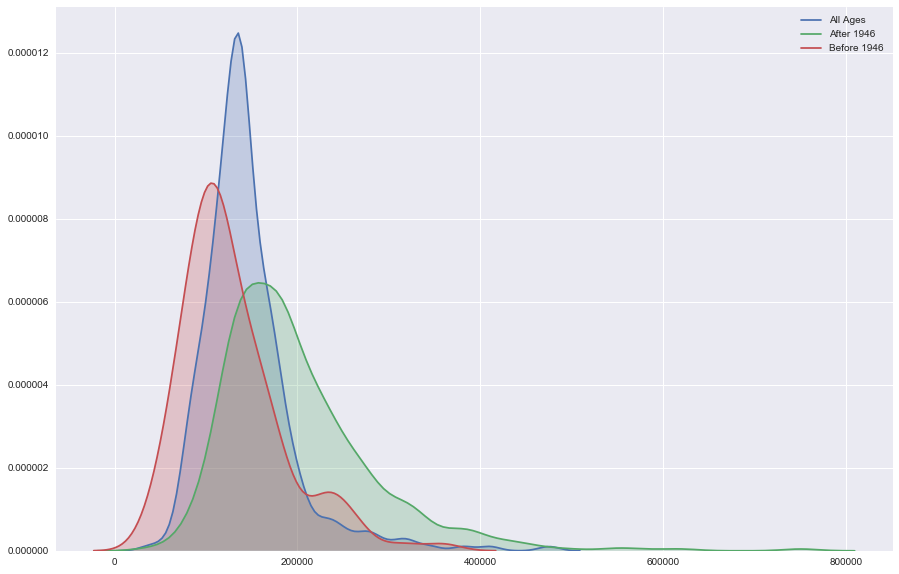

In [10]:
sns.kdeplot(train.loc[train.Years == 2, 'SalePrice'], shade=True, label='All Ages')
sns.kdeplot(train.loc[train.Years == 0, 'SalePrice'], shade=True, label='After 1946')
sns.kdeplot(train.loc[train.Years == 1, 'SalePrice'], shade=True, label='Before 1946')

Newer houses have higher prices than older houses. All ages houses have prices in between.

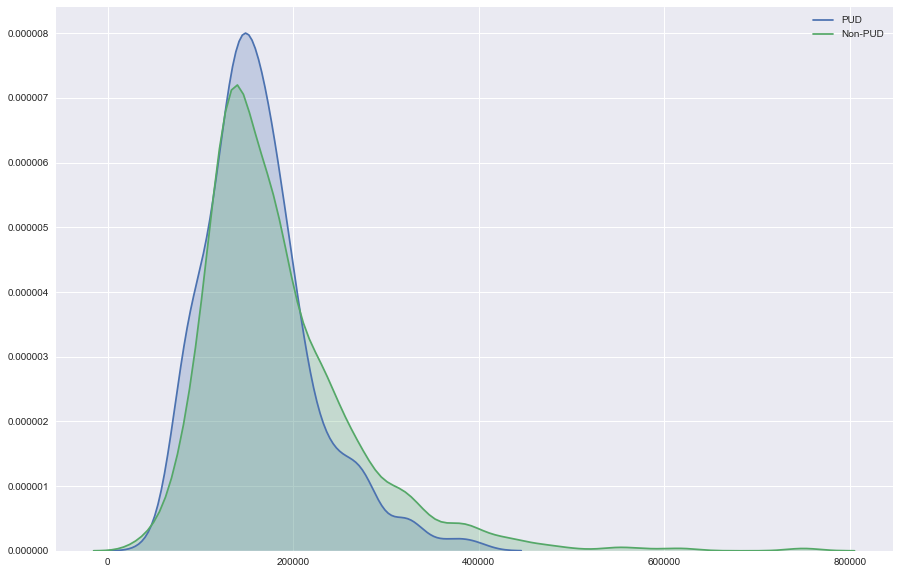

In [11]:
pud_mapping = {20: 0, 30: 0, 40: 0, 45: 0, 50: 0, 60: 0, 70: 0, 75: 0, 80: 0, 85: 0, 90: 0, 120: 1, 150: 1, 160: 1, 180: 1, 
                190: 1}
train['PUD'] = train.MSSubClass.map(pud_mapping)

sns.set(rc={'figure.figsize':(15,10)})
sns.kdeplot(train.loc[train.PUD == 1, 'SalePrice'], shade=True, label='PUD')
sns.kdeplot(train.loc[train.PUD == 0, 'SalePrice'], shade=True, label='Non-PUD')

Doesn't look like much of a difference between PUD and non-PUD houses

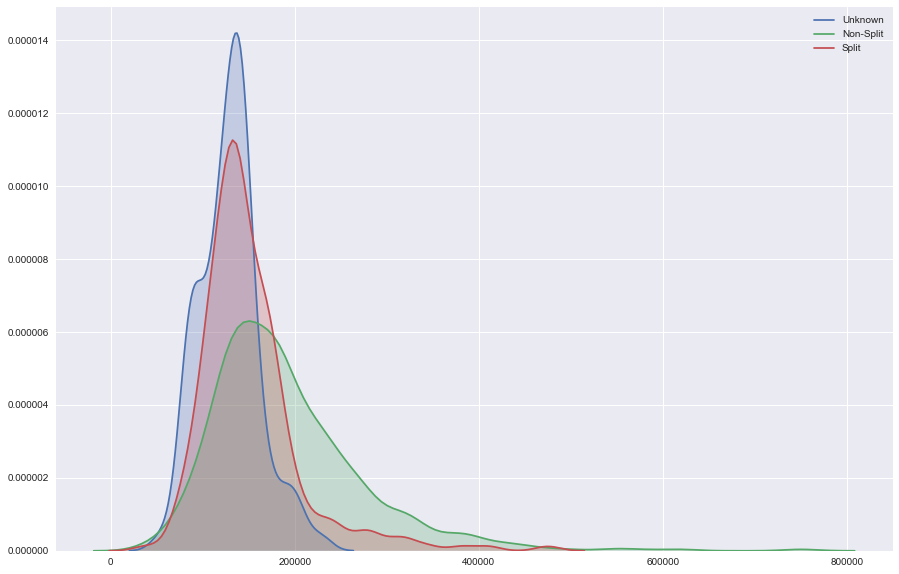

In [12]:
split_mapping = {20: 0, 30: 0, 40: 0, 45: 1, 50: 1, 60: 0, 70: 0, 75: 1, 80: 1, 85: 1, 90: 2, 120: 0, 150: 1, 160: 0, 180: 2, 
                190: 2}
train['Split'] = train.MSSubClass.map(split_mapping)

sns.set(rc={'figure.figsize':(15,10)})
sns.kdeplot(train.loc[train.Split == 2, 'SalePrice'], shade=True, label='Unknown')
sns.kdeplot(train.loc[train.Split == 0, 'SalePrice'], shade=True, label='Non-Split')
sns.kdeplot(train.loc[train.Split == 1, 'SalePrice'], shade=True, label='Split')

In [13]:
train.groupby('Split')['SalePrice'].median()

Split
0    176000
1    139000
2    132000
Name: SalePrice, dtype: int64

Non-split level homes are more expensive.

What kind of models can we make with just this variable? For starters what happens if we simply predict the median value for each category?

In [15]:
test = pd.read_csv('../data/test.csv', index_col=0)

In [16]:
test['MSSubClass'].value_counts()

20     543
60     276
50     143
120     95
30      70
70      68
160     65
80      60
90      57
190     31
85      28
180      7
75       7
45       6
40       2
150      1
Name: MSSubClass, dtype: int64

We run into a problem here where the test data has an instance of a category that the train data doesn't have, 1-1/2 STORY PUD - ALL AGES. We have no median value to use. Since we have seen the age of the home and the levels in the home are useful and that the PUD status is not, we'll use the median value for 1.5 story all age homes.

In [17]:
median_price_by_mssubclass[150] = train.loc[(train.Floors == 1.5) & (train.Years == 2), 'SalePrice'].median()

In [18]:
predictions = test['MSSubClass'].map(median_price_by_mssubclass)
submission = pd.DataFrame(columns=['Id', 'SalePrice'])
submission['Id'] = test.index
submission['SalePrice'] = predictions
submission.to_csv('mssubclass_only.csv', index=False)

This model did quite poorly and achieved a RMSE of 0.34683, ranking it 4611 out of 4937 (as of 06/25/18). What if we stick this varible into a random forest regressor?

In [19]:
def transform_data(data, label_encoder, one_hot_encoder):
    labels = label_encoder.transform(data).reshape(-1, 1)
    one_hots = one_hot_encoder.transform(labels)
    return one_hots

In [20]:
all_data = pd.concat([train, test])
label_encoder = LabelEncoder()
label_encoder.fit(all_data['MSSubClass'])
mssubclass_labels = label_encoder.transform(all_data['MSSubClass']).reshape(-1, 1)
one_hot_encoder = OneHotEncoder()
one_hot_encoder.fit(mssubclass_labels)

OneHotEncoder(categorical_features='all', dtype=<class 'numpy.float64'>,
       handle_unknown='error', n_values='auto', sparse=True)

In [21]:
train_X = train['MSSubClass'].copy()
train_y = train['SalePrice'].copy()
train_X_prep = transform_data(train_X, label_encoder, one_hot_encoder)
params = {
    'max_depth': randint(2, 400),
    'min_samples_split': randint(2, 100),
}
rnd_clf = RandomForestRegressor(n_estimators=500)
forest_search = RandomizedSearchCV(rnd_clf, param_distributions=params, n_iter=400, n_jobs=6)
forest_search.fit(train_X_prep, train_y)
final_model = forest_search.best_estimator_

In [22]:
test_X = test['MSSubClass'].copy()
test_X_prep = transform_data(test_X, label_encoder, one_hot_encoder)
predictions = final_model.predict(test_X_prep)
submission_df = pd.DataFrame(
    data=predictions,
    index=test.index,
    columns=['SalePrice']
)
submission_df.to_csv('submission.csv')

This model did worse with a RMSE of 0.34893. Let's try using the features we engineered (Floors, Years, PUD, and Split) instead of the raw variable. First we'll need to add these features to the test data first.

In [23]:
test['Floors'] = test.MSSubClass.map(floor_mapping)
test['Years'] = test.MSSubClass.map(year_mapping)
test['PUD'] = test.MSSubClass.map(pud_mapping)
test['Split'] = test.MSSubClass.map(split_mapping)

In [24]:
all_data = pd.concat([train, test]).loc[:, ['Floors', 'Years', 'PUD', 'Split']]
label_encoder = LabelEncoder()
label_encoder.fit(all_data['Floors'])
all_data['Floors'] = label_encoder.transform(all_data['Floors']).reshape(-1, 1)
one_hot_encoder = OneHotEncoder()
one_hot_encoder.fit(all_data.loc[:, ['Floors', 'Years', 'PUD', 'Split']])

OneHotEncoder(categorical_features='all', dtype=<class 'numpy.float64'>,
       handle_unknown='error', n_values='auto', sparse=True)

In [25]:
train_X = train.loc[:, ['Floors', 'Years', 'PUD', 'Split']].copy()
train_X['Floors'] = label_encoder.transform(train_X['Floors']).reshape(-1, 1)
train_X_prep = one_hot_encoder.transform(train_X)

In [26]:
params = {
    'max_depth': randint(2, 400),
    'min_samples_split': randint(2, 100),
}
rnd_clf = RandomForestRegressor(n_estimators=500)
forest_search = RandomizedSearchCV(rnd_clf, param_distributions=params, n_iter=400, n_jobs=6)
forest_search.fit(train_X_prep, train_y)
final_model = forest_search.best_estimator_

In [27]:
test_X = test.loc[:, ['Floors', 'Years', 'PUD', 'Split']].copy()
test_X['Floors'] = label_encoder.transform(test_X['Floors']).reshape(-1, 1)
test_X_prep = one_hot_encoder.transform(test_X)
predictions = final_model.predict(test_X_prep)
submission_df = pd.DataFrame(
    data=predictions,
    index=test.index,
    columns=['SalePrice']
)
submission_df.to_csv('submission.csv')

This model did even worse with a RMSE of 0.34911. As of right now, I can't think of any other way to use just this variable, so let's go back to some exploratory analysis.

In [2]:
train = pd.read_csv('../data/train.csv', index_col=0)

MSSubClass is an unordered categorical variable. For testing association, we'll use a corrected Cramer's V test to get association strength with other unordered categorical variables.

In [6]:
association_matrix(train, 'MSSubClass', categorical_unordered_columns)

BldgType         0.891384
HouseStyle       0.847975
Alley            0.614787
CentralAir       0.434347
GarageFinish     0.415999
Neighborhood     0.373738
Foundation       0.359476
GarageType       0.351670
MSZoning         0.337298
MiscFeature      0.279946
MasVnrType       0.229882
RoofStyle        0.216762
Exterior2nd      0.202989
Exterior1st      0.192750
Electrical       0.175859
LotShape         0.164319
Condition2       0.157432
SaleCondition    0.151900
Heating          0.149986
LandContour      0.140495
Condition1       0.110788
Street           0.091705
SaleType         0.090476
LandSlope        0.086814
RoofMatl         0.080189
LotConfig        0.078722
MoSold           0.019368
Utilities        0.000000
MSSubClass            NaN
dtype: float64

We can see that MSSubClass has a very strong association with BldgType and HouseStyle. Looking at the descriptions of these variables, we see that the possible values are very similar to the values of MSSubClass. It is likely that including these variables together in a model would do more harm than good. We'll probably still try it (using automated feature selection), but I don't think it'll be the winning model.

I don't know how to measure association between nominal and ordinal variables, so I'll just treat the ordinal variables as nominal variables.

In [3]:
association_matrix(train, 'MSSubClass', categorical_ordered_columns)

HalfBath        0.533329
KitchenAbvGr    0.493818
YearBuilt       0.372296
BsmtQual        0.346590
BedroomAbvGr    0.338227
FullBath        0.312587
PavedDrive      0.309413
GarageYrBlt     0.300409
GarageCars      0.294848
PoolQC          0.288675
ExterQual       0.285100
KitchenQual     0.282906
TotRmsAbvGrd    0.262143
BsmtExposure    0.253446
BsmtFullBath    0.239426
HeatingQC       0.239246
YearRemodAdd    0.222919
Fireplaces      0.220205
GarageQual      0.219919
BsmtFinType1    0.218031
OverallQual     0.202211
OverallCond     0.189693
GarageCond      0.175180
ExterCond       0.167239
BsmtCond        0.153168
FireplaceQu     0.152975
Fence           0.146033
Functional      0.096797
BsmtHalfBath    0.083661
BsmtFinType2    0.082386
YrSold          0.000000
dtype: float64

Nothing pops out extremely high. Let's look at the breakdown of HalfBath by MSSubClass though.

In [5]:
pd.crosstab(train['MSSubClass'], train['HalfBath'])

HalfBath,0,1,2
MSSubClass,,,
20,453,83,0
30,68,1,0
40,3,1,0
45,12,0,0
50,97,47,0
60,9,286,4
70,34,26,0
75,10,6,0
80,41,17,0


Looks like almost every new 2 story house has a halfbath. Almost all of the new 2 story PUD houses do as well. A significant amount of new 1 story homes have a halfbath, as do 1-1/2 story finished houses of all ages. The only old home category with a significant amount of halfbath homes is the old 2 story homes, which we would think would be the most likely. As for homes with 2 half bath, duplexes are the only category with a significant amount which is essentially 1 per family. HalfBath may wind up to be more associated with age of the home and number of floors.

Let's now take a look at the correlations and effect sizes between MSSubClass and all of the continuous variables.

In [3]:
anova_matrix(train, 'MSSubClass', continuous_columns)

,p_value,effect_size
2ndFlrSF,0,0.966926
GrLivArea,1.78949e-136,0.802486
LotFrontage,4.51601e-91,0.726217
1stFlrSF,4.74012e-75,0.67439
TotalBsmtSF,3.5833e-62,0.629329
GarageArea,1.05681e-51,0.584015
LowQualFinSF,4.4317e-44,0.544401
EnclosedPorch,9.8033e-39,0.512331
OpenPorchSF,1.08587e-27,0.430854
BsmtFinSF1,1.25782e-26,0.421628


It makes sense that 2ndFlrSF and GrLivArea are highly correlated. Since we know information about the number of floors in the house is contained in this variable, 2ndFlrSF should be correlated. And since number of floors in a house will greatly influence the living area square footage, it makes sense for GrLivArea to be highly correlated.

It's more interesting to me that LotFrontage has the next highest correlation. Let's see what categories have the highest LotFrontages.

c:\users\daniel\anaconda5.0.1-python3.6\lib\site-packages\seaborn\categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


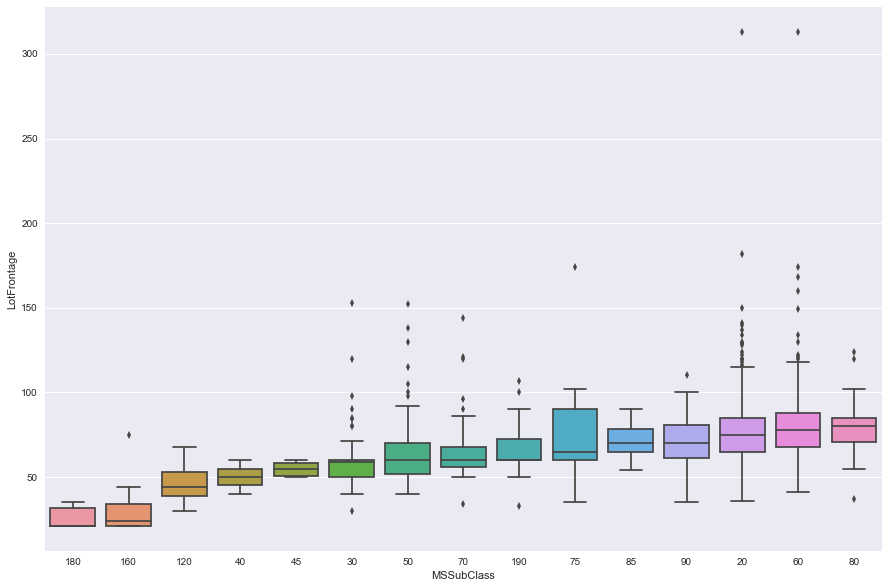

In [7]:
lotfrontage_order = train.groupby('MSSubClass').median()['LotFrontage'].sort_values().index
sns.boxplot(x='MSSubClass', y='LotFrontage', order=lotfrontage_order, data=train);

Sadly, I don't know what to make of this. I can't see any pattern or groupings that matter.

And with that, I don't really have anything else I'm interested in looking into with MSSubClass. We learned this variable contains some information about the number of floors, the age, PUD status, and split level status of houses. Sadly, this information alone did not produce a very accurate model.